In [1]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Build model with model_architecture.json

In [2]:
import os
import json
import flwr as fl

with open('../Server/model_architecture.json','r') as file:
    json_data = file.read()
model_architecture = json.loads(json_data)
model = tf.keras.models.model_from_json(model_architecture)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0

## Load the latest weights

In [3]:
import numpy as np

files_list=[]
# check every file under the root directory to have .npy extension
for root, dirs, files in os.walk('../Server/fl_sessions/', topdown = False):
    for file in files:
        if file.endswith(".npy"):
            files_list.append(os.path.join(root,file))
# get the latest file
latest_params_file = max(files_list, key=os.path.getmtime)
# load the weights from the file
latest_params=np.load(latest_params_file,allow_pickle=True)

latest_weights = fl.common.parameters_to_ndarrays(latest_params[0])

model.set_weights(latest_weights)


## Run predict and plot confussion matrix


In [4]:
(_,_),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
y_test = y_test.reshape(-1)
predictions = model.predict(x_test)

313/313 [==============================] - 8s 2ms/step


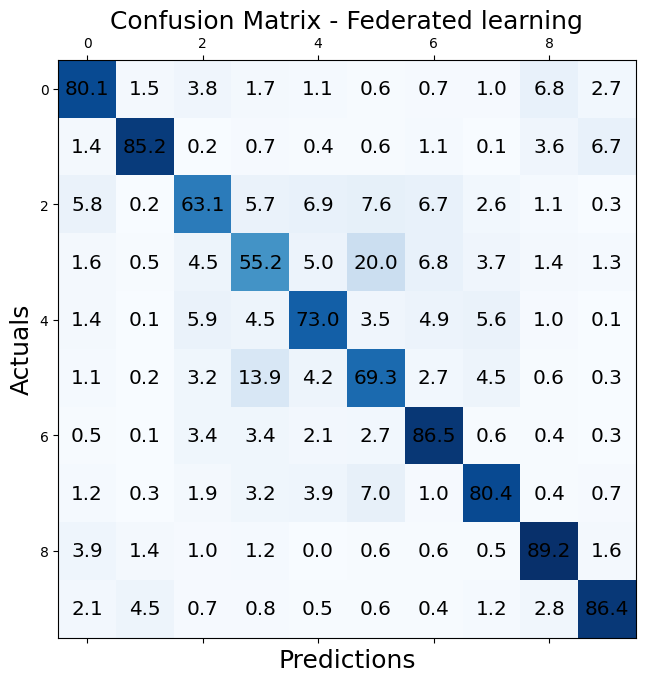

In [9]:
import matplotlib.pyplot as plt
model_preds = predictions.argmax(axis=1)

confusion  = tf.math.confusion_matrix(
    labels=y_test,
    predictions=model_preds,
    num_classes=10    
)
conf_matrix = np.array(confusion)
# print(conf_matrix)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha = 1)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j]/10, va='center', ha='center', size='x-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Federated learning', fontsize=18)
plt.show()        
plt.show()

## Plot the loss and accuracy

[0.4937500059604645, 0.612499992052714, 0.662500003973643, 0.706250011920929, 0.712499996026357, 0.7197916706403097, 0.740625003973643, 0.7552083333333334, 0.756250003973643, 0.7583333253860474] [1.5203241109848022, 1.0940471092859905, 0.9550847212473551, 0.873913586139679, 0.8390470345815023, 0.8557895024617513, 0.7830351193745931, 0.7536531289418539, 0.7682215372721354, 0.7662431995073954]


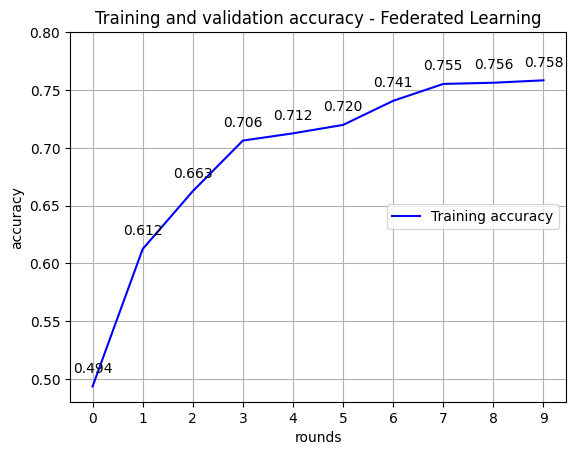

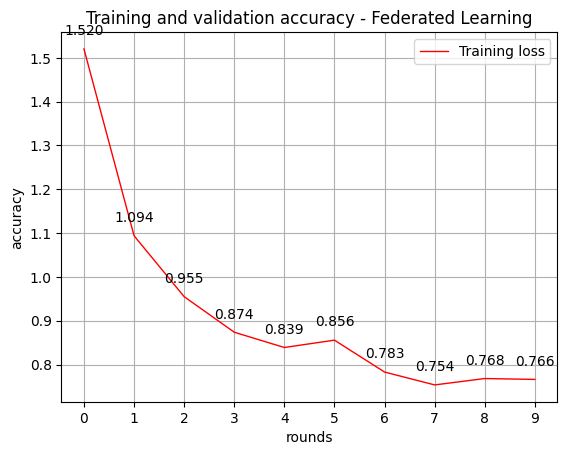

In [38]:
with open('./temp/FL_result.json','r') as json_data:
    result = json.load(json_data)
    acc = list(result['aggregated_accuracy'].values())
    loss = list(result['aggregated_loss'].values())


acc.remove(0)
loss.remove(0)
print(acc,loss)

rounds = range(len(acc))

plt.grid()
plt.plot(rounds, acc, 'b', label='Training accuracy')
# plt.plot(rounds, loss, 'r', linestyle='dashed', linewidth=1, label='Training loss')
plt.title('Training and validation accuracy - Federated Learning')
plt.xlabel('rounds')
plt.xticks(rounds)
plt.yticks(np.arange(0.5, 0.8, step=0.05))
for x,y in zip(rounds,acc):
    label = "{:.3f}".format(y)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')
    
plt.ylabel('accuracy')
plt.legend(loc=5)
plt.show()

plt.grid()
# plt.plot(rounds, acc, 'b', label='Training accuracy')
plt.plot(rounds, loss, 'r', linewidth=1, label='Training loss')
plt.title('Training and validation accuracy - Federated Learning')
plt.xlabel('rounds')
plt.xticks(rounds)
plt.ylabel('accuracy')
plt.legend(loc=0)
for x,y in zip(rounds,loss):
    label = "{:.3f}".format(y)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')
plt.show()